In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

## Estimates from Sample Covariance

The portfolios we constructed in this notebook serve as reference to the portfolios using cosine similarity estimates and factor model estimates. Here, we simply use the sample return and sample covariance to generate portfolios for each industry.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
r_selected = pd.read_csv("data/filtered_r.csv")
# get the mean of all 
r_selected.set_index("name", inplace = True)
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

### Perform Mean-Variance Analysis
We will use one industry per time to generate a minimum-variance portfolio. In our demonstration of mean-variance analysis process, we use the industry `pharmaceutical preparations` whose SIC code is `2834`. At the end, we will show the results for other industries. 

We first get the name list of `pharmaceutical preparations` companies and match the names with the companies in returns data. Then, we get the sample mean and sample covariance for this specific industry. We get the efficient frontier, the set of optimal portfolios, for the industry; and recognize the minimum-variance portfolio with its performance and its weights for selected companies.

In [4]:
#!pip install dataframe_image

In [5]:
!pip install PyPortfolioOpt

In [6]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

In [7]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

In [8]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [9]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

#### Sample Mean for the Pharmaceutical Preparations Industry

In [10]:
mu_Pharm = mu[LIST]
mu_Pharm

name
JOHNSON & JOHNSON                0.007494
SYNTHETIC BIOLOGICS, INC.       -0.117010
FORTRESS BIOTECH, INC.          -0.019867
PARATEK PHARMACEUTICALS, INC.   -0.024066
ARQULE INC                       0.043046
                                   ...   
ZOSANO PHARMA CORP              -0.045029
ONCOMED PHARMACEUTICALS INC     -0.065967
PTC THERAPEUTICS, INC.           0.081859
WAVE LIFE SCIENCES LTD.          0.048065
ONCOSEC MEDICAL INC             -0.009135
Length: 124, dtype: float64

#### Sample Covariance for the Pharmaceutical Preparations Industry

In [11]:
tmp = cov[LIST].T
cov_Pharm = tmp[LIST]
cov_Pharm

name,JOHNSON & JOHNSON,"SYNTHETIC BIOLOGICS, INC.","FORTRESS BIOTECH, INC.","PARATEK PHARMACEUTICALS, INC.",ARQULE INC,OPHTHOTECH CORP.,"FIBROCELL SCIENCE, INC.",ENANTA PHARMACEUTICALS INC,PORTOLA PHARMACEUTICALS INC,"ARATANA THERAPEUTICS, INC.",...,FLEXION THERAPEUTICS INC,"PRESTIGE BRANDS HOLDINGS, INC.",GALECTIN THERAPEUTICS INC,CATABASIS PHARMACEUTICALS INC,"TELIGENT, INC.",ZOSANO PHARMA CORP,ONCOMED PHARMACEUTICALS INC,"PTC THERAPEUTICS, INC.",WAVE LIFE SCIENCES LTD.,ONCOSEC MEDICAL INC
name,,,,,,,,,,,,,,,,,,,,,
JOHNSON & JOHNSON,0.001999,0.000114,0.002340,0.001234,-0.001739,0.000064,-0.000474,-0.001219,0.001758,0.000081,...,0.000971,0.001312,0.002841,-0.003584,0.002300,0.005264,0.001195,-0.002392,-0.000148,0.001495
"SYNTHETIC BIOLOGICS, INC.",0.000114,0.047660,0.014484,0.013074,0.010385,0.006243,0.008238,0.006687,0.013118,-0.000307,...,0.010925,0.001726,0.006691,0.017695,0.002601,0.002134,0.017007,0.005679,-0.001993,-0.003392
"FORTRESS BIOTECH, INC.",0.002340,0.014484,0.034730,0.015315,0.004847,0.001813,0.011941,0.007231,0.019865,0.000885,...,0.019194,0.004825,0.021772,0.007904,0.001940,0.020079,0.010251,0.007095,0.001004,-0.005132
"PARATEK PHARMACEUTICALS, INC.",0.001234,0.013074,0.015315,0.026534,0.002726,0.004201,0.014456,0.006998,0.011105,0.000014,...,0.010004,0.005227,0.012742,0.014110,0.008246,0.005180,0.013125,0.012638,-0.002179,-0.007654
ARQULE INC,-0.001739,0.010385,0.004847,0.002726,0.072106,0.018259,0.002874,0.006279,0.000991,0.007196,...,0.005015,0.008378,0.019332,0.013532,0.008357,0.000944,0.024511,0.017331,0.010765,0.014953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZOSANO PHARMA CORP,0.005264,0.002134,0.020079,0.005180,0.000944,-0.001984,0.018302,-0.004360,0.025531,0.000189,...,0.006360,0.011443,0.045296,-0.022670,0.013413,0.106290,0.020324,0.011539,-0.002791,0.007832
ONCOMED PHARMACEUTICALS INC,0.001195,0.017007,0.010251,0.013125,0.024511,0.019946,0.001846,-0.000963,0.007101,0.001275,...,0.014779,0.002398,0.002101,0.009534,0.005586,0.020324,0.048878,0.001692,0.015326,0.017584
"PTC THERAPEUTICS, INC.",-0.002392,0.005679,0.007095,0.012638,0.017331,-0.001052,0.024321,0.023870,0.014432,0.008186,...,-0.002383,0.004181,0.011845,0.021288,0.008459,0.011539,0.001692,0.077202,0.009859,-0.011324


#### Efficient Frontier - Pharmaceutical Preparations

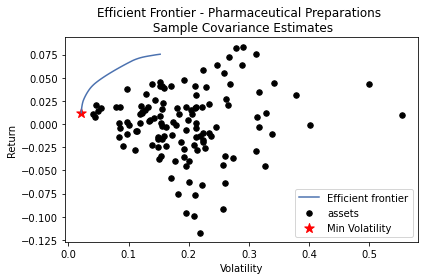

In [12]:
ef1 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, cov_Pharm, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - Pharmaceutical Preparations \n Sample Covariance Estimates")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Sample_Pharmaceutical_Preparations.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Sample_Pharmaceutical_Preparations.png](images/Efficient_Frontier_Sample_Pharmaceutical_Preparations.png)

##### Min Volatility Portfolio

###### Performance

In [13]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.2%
Annual volatility: 2.1%
Sharpe Ratio: -0.35


###### Weights

In [14]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_sample_Pharmaceutical_Preparations.csv", index = False)

In [15]:
pd.read_csv("data/min_vol_sample_Pharmaceutical_Preparations.csv")

,Company_Name,Weight
0,JOHNSON & JOHNSON,0.17878
1,"ARATANA THERAPEUTICS, INC.",0.03678
2,PFENEX INC.,0.03777
3,"MERCK & CO., INC.",0.20000
4,ZOETIS INC.,0.01195
5,LIPOCINE INC.,0.00683
6,"RECRO PHARMA, INC.",0.02010
7,VTV THERAPEUTICS INC.,0.02372
8,ACHAOGEN INC,0.00515
9,"HEAT BIOLOGICS, INC.",0.00297


### Results for the Other 4 Industries

In [16]:
SIC_list = [7372, 1311, 6798, 6022]
SIC_desc = ['Prepackaged Software (mass reproduction of software)', 'Crude Petroleum and Natural Gas', 
           'Real Estate Investment Trusts', 'State Commercial Banks (commercial banking)']

#### Prepackaged Software (mass reproduction of software)

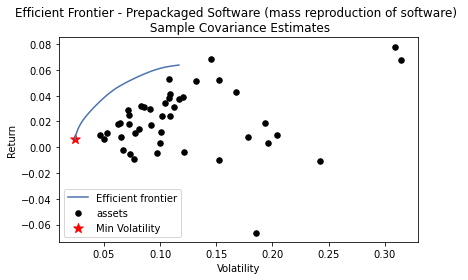

In [17]:
SIC = SIC_list[0]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

tmp = cov[LIST].T
cov_sample = tmp[LIST]

# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_sample, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_sample, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Sample Covariance Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Sample_Covariance_Estimates_Prepackaged_Software.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Sample_Covariance_Estimates_Prepackaged_Software.png](images/Efficient_Frontier_Sample_Covariance_Estimates_Prepackaged_Software.png)

##### Min Volatility Portfolio

###### Performance

In [18]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.6%
Annual volatility: 2.4%
Sharpe Ratio: -0.57


###### Weights

In [19]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_sample_Prepackaged_Software.csv", index = False)

In [20]:
pd.read_csv("data/min_vol_sample_Prepackaged_Software.csv")

,Company_Name,Weight
0,AWARE INC /MA/,0.20000
1,"AVID TECHNOLOGY, INC.",0.00129
2,"ENDURANCE INTERNATIONAL GROUP HOLDINGS, INC.",0.02554
3,ROSETTA STONE INC,0.01647
4,COMMVAULT SYSTEMS INC,0.07381
5,ORACLE CORP,0.09170
6,MAJESCO,0.01906
7,"QUALYS, INC.",0.06668
8,"BLACK KNIGHT, INC.",0.20000
9,QUMU CORP,0.05153


#### Crude Petroleum and Natural Gas
When we conduct the same analysis, there is no weight shown. Efficient frontier cannot be found.

#### Real Estate Investment Trusts

In [21]:
SIC = SIC_list[2]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

tmp = cov[LIST].T
cov_sample = tmp[LIST]

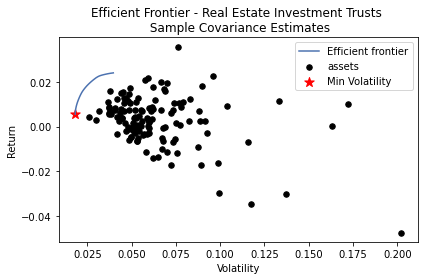

In [22]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_sample, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_sample, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Sample Covariance Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Sample_Covariance_Estimates_Real_Estate_Investment_Trusts.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Sample_Covariance_Estimates_Real_Estate_Investment_Trusts.png](images/Efficient_Frontier_Sample_Covariance_Estimates_Real_Estate_Investment_Trusts.png)

##### Min Volatility Portfolio

###### Performance

In [23]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.5%
Annual volatility: 1.8%
Sharpe Ratio: -0.80


###### Weights

In [24]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_sample_Real_Estate_Investment_Trusts.csv", index = False)

In [25]:
pd.read_csv("data/min_vol_sample_Real_Estate_Investment_Trusts.csv")

,Company_Name,Weight
0,PUBLIC STORAGE,0.10938
1,NEW YORK MORTGAGE TRUST INC,0.02084
2,"MANHATTAN BRIDGE CAPITAL, INC",0.01483
3,EQUITY COMMONWEALTH,0.20000
4,BRT APARTMENTS CORP.,0.01724
5,ALEXANDERS INC,0.02285
6,CROWN CASTLE INTERNATIONAL CORP,0.04875
7,IMPAC MORTGAGE HOLDINGS INC,0.05108
8,CIM COMMERCIAL TRUST CORP,0.05461
9,GREAT AJAX CORP.,0.20000


#### State Commercial Banks (commercial banking)

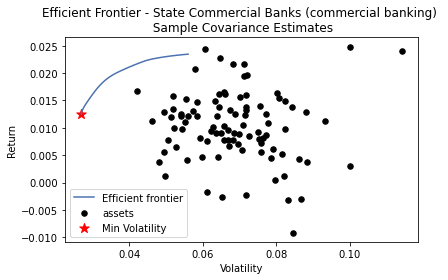

In [26]:
SIC = SIC_list[3]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

tmp = cov[LIST].T
cov_sample = tmp[LIST]

# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_sample, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_sample, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Sample Covariance Estimates" %industry_name)
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Sample_Covariance_Estimates_State_Commercial_Banks.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Sample_Covariance_Estimates_State_Commercial_Banks.png](images/Efficient_Frontier_Sample_Covariance_Estimates_State_Commercial_Banks.png)

##### Min Volatility Portfolio

###### Performance

In [27]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.2%
Annual volatility: 2.7%
Sharpe Ratio: -0.28


###### Weights

In [28]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_sample_State_Commercial_Banks.csv", index = False)

In [29]:
pd.read_csv("data/min_vol_sample_State_Commercial_Banks.csv")

,Company_Name,Weight
0,BANK OF THE JAMES FINANCIAL GROUP INC,0.00178
1,BANK OF NEW YORK MELLON CORP,0.09533
2,CITIZENS & NORTHERN CORP,0.05375
3,"FAUQUIER BANKSHARES, INC.",0.02143
4,VILLAGE BANK & TRUST FINANCIAL CORP.,0.13994
5,FIRST COMMUNITY CORP /SC/,0.05076
6,GUARANTY FEDERAL BANCSHARES INC,0.17724
7,"RELIANT BANCORP, INC.",0.12273
8,"CAROLINA TRUST BANCSHARES, INC.",0.11786
9,MACKINAC FINANCIAL CORP /MI/,0.02478
